## Fine-tuning pour la classification


In [ ]:
from typing import Optional, Mapping, Any, Tuple

import pandas as pd

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

from gptlight.tokenizer import GPTTokenizer
from gptlight.models import GPTModel
from gptlight.config import GPTConfig
from gptlight.training import Trainer, load_model, save_model, classification_loss
from gptlight.utils import fetch_sms_spam_collection
from gptlight.data import ClassifcationDataset

2025-12-03 02:56:26.426300: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
torch.manual_seed(123)
if torch.cuda.is_available():
    torch.cuda.manual_seed(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device : {device}")

device : cpu


In [3]:
tokenizer = GPTTokenizer()

Jusqu'ici, nous avons code l'architecture du LLM, effectue le pre-entrainement et appris a importer des poids pre-entraines depuis une source externe comme OpenAI. Il est temps d'en recolter les fruits en ajustant le LLM sur une tâche cible, par exemple la classification de texte. L'exemple concret etudié consiste à déterminer si un message est "spam" ou "not spam".


## Différentes catégories de fine-tuning


Les approches de fine-tuning les plus courantes sont le fine-tuning par instructions et le fine-tuning pour la classification. Le fine-tuning par instructions entraine le modèle sur des tâches décrites en langage naturel afin d'ameliorer son comprehension des consignes.

Le fine-tuning pour la classification, familier a tout praticien de l'apprentissage automatique, apprend au modèle à reconnaitre un ensemble de classes ("spam" vs "not spam", par exemple). Les applications incluent aussi bien l'identification d'especes vegetales a partir d'images que la categorisation d'articles (sport, politique, technologie) ou la distinction tumeurs benignes/malignes.

Un modèle classeur reste limité aux étiquettes vues pendant l'entraînement. A l'inverse, un modèle ajusté par instructions reste généraliste mais est plus difficile à développer.


## Choisir la bonne approche

Le fine-tuning par instructions augmente la flexibilite du modele pour repondre a des consignes complexes et variees. Il necessite toutefois davantage de donnees et de calcul. Le fine-tuning pour la classification est ideal lorsque l'on souhaite affecter des etiquettes predefinies (analyse de sentiment, detection de spam) avec un volume de donnees reduit. Le choix depend donc du type de taches visees et des ressources disponibles.


## Preparation du jeu de donnees


Nous allons modifier puis ajuster pour la classification le GPT precedemment implemente et pre-entraine. Premieres etapes : telecharger et preparer le jeu de donnees.


> Nous utilisons la methode `fetch_sms_spam_collection` du module `gptlight.datasets` pour telecharger le corpus dans un DataFrame pandas.


In [4]:
df = fetch_sms_spam_collection()
df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Observons la distribution des etiquettes :


In [5]:
df["Label"].value_counts()

Label
ham     4825
spam     747
Name: count, dtype: int64

Pour rester sur un corpus reduit (ce qui accelere le fine-tuning), nous sous-echantillonnons le jeu de donnees pour conserver 747 exemples par classe.


In [6]:
num_spam = sum(df.Label=="spam")
ham_subset = df[df.Label=="ham"].sample(num_spam, random_state=123)
df_subset = pd.concat([
    ham_subset, df[df.Label=="spam"]
])
df_subset["Label"].value_counts()

Label
ham     747
spam    747
Name: count, dtype: int64

Nous convertissons ensuite les etiquettes textuelles "ham" et "spam" en valeurs entieres 0 et 1 :


In [7]:
df_subset["Label"] = df_subset["Label"].map({"ham":0, "spam":1})

Nous definissons enfin `random_split` afin de separer les donnees en 70 % train, 10 % validation et 20 % test.


In [8]:
def random_split(df:pd.DataFrame, train_frac, val_frac, random_state=None):
    
    df = df.sample(
        frac=1, random_state=random_state
    ).reset_index(drop=True)
    
    train_end = int(len(df)*train_frac)
    val_end = train_end + int(len(df)*val_frac)
    
    train_df = df[:train_end]
    val_df = df[train_end:val_end]
    test_df = df[val_end:]
    
    return train_df, val_df, test_df

In [9]:
train_df, val_df, test_df = random_split(df_subset, train_frac=0.7, val_frac=0.1, random_state=123)

## Creation des data loaders


Auparavant, nous utilisions des fenetres glissantes de taille fixe pour produire des batches homogenes. Les messages SMS ont des longueurs variables, nous devons donc uniformiser les sequences au sein d'un batch.

Deux options : tronquer tous les messages a la longueur minimale, ou completer chaque message jusqu'a la longueur maximale. La troncature peut supprimer trop d'information; nous choisissons donc le padding.

Concretement, nous ajoutons des tokens de remplissage jusqu'a atteindre la longueur maximale observee, en reutilisant le token `<|endoftext|>` (ID 50256) directement au niveau des IDs plutot qu'au niveau texte.


> Consultez la classe `ClassificationDataset` dans `gptlight.data.datasets` pour voir comment ces etapes sont mise en oeuvre.


In [10]:
train_dataset = ClassifcationDataset(
    input_texts=train_df["Text"],
    target_labels=train_df["Label"],
    tokenizer=tokenizer
)

La plus longue sequence est accessible via l'attribut `max_length` du dataset.


In [11]:
print(train_dataset.max_length)

120


Le programme affiche 120 : la sequence la plus longue comprend 120 tokens, ce qui reste bien en dessous de la longueur de contexte 1 024 du modele. Si vos textes depassent cette limite, passez `max_length=1024` pour rester compatible avec GPT-2.


Nous appliquons ensuite le meme padding aux ensembles de validation et de test, en tronquant eventuellement les sequences qui excederaient la longueur maximale du train.


In [12]:
val_dataset = ClassifcationDataset(
    input_texts=val_df["Text"],
    target_labels=val_df["Label"],
    max_lenght=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = ClassifcationDataset(
    input_texts=test_df["Text"],
    target_labels=test_df["Label"],
    max_lenght=train_dataset.max_length,
    tokenizer=tokenizer
)

> Creation des DataLoader PyTorch


In [14]:
num_workers =0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True
)

In [15]:
input_batch, target_batch = next(iter(train_loader))
print(input_batch, target_batch)

tensor([[   56,    64,   655,  5149,   450,    83,   294,    83,  4519,   492,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
        [   40,  1464,  8537,   351,   345,    13, 

In [16]:
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


Chaque batch contient huit exemples de 120 tokens, et le tenseur de labels fournit les classes correspondantes.


## Initialiser un modele avec des poids pre-entraines


In [17]:
GPT_SMALL_CONFIG_124M = GPTConfig(
    vocab_size=50257,
    context_length=1024,
    emb_dim=768,
    n_heads=12,
    n_layers=12,
    drop_rate=0.0,
    qkv_bias=True
)
INPUT_PROMPT = "Every effort moves"
gpt_model = GPTModel(GPT_SMALL_CONFIG_124M)
gpt_model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): GPTTransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): GPTTransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_feat

In [98]:
state = load_model(path="../assets/checkpoints/gpt.pt", device=device)
gpt_model.load_state_dict(state_dict=state["model_state"])

<All keys matched successfully>

In [19]:
torch.manual_seed(123)
tokenizer = GPTTokenizer()
token_ids = gpt_model.generate(
    idx=tokenizer.encode(INPUT_PROMPT).unsqueeze(0).to(device),
    max_new_tokens=15,
    context_size=GPT_SMALL_CONFIG_124M.context_length,
    top_k=15,
    temperature=1.5
)
print("Output text:\n", tokenizer.decode(token_ids))

Output text:
 Every effort moves slowly and slowly in all parts of the galaxy, from asteroids to space and


Avant le fine-tuning, testons le modele actuel avec une instruction pour voir s'il sait deja detecter le spam :


In [20]:
torch.manual_seed(123)
text = (
"Is the following text 'spam'? Answer with 'yes' or 'no':"
" 'You are a winner you have been specially"
" selected to receive $1000 cash or a $2000 award.'"
)
token_ids = gpt_model.generate(
    idx=tokenizer.encode(text).unsqueeze(0).to(device),
    max_new_tokens=23,
    context_size=GPT_SMALL_CONFIG_124M.context_length,
    #top_k=15,
    #temperature=1.5
)
print("Output text:\n", tokenizer.decode(token_ids))

Output text:
 Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


La reponse montre qu'il suit mal la consigne, ce qui est logique : seul le pre-entrainement a ete effectue. Passons a la preparation pour la classification.


## Ajouter une tete de classification


Pour adapter le LLM, nous remplaçons la tete de sortie (50 257 dimensions) par une couche ne renvoyant que deux logits (0 = not spam, 1 = spam). Commencons par afficher l'architecture actuelle pour savoir ce que nous modifions.


In [99]:
print(gpt_model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): GPTTransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): GPTTransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_feat

Jusqu'ici, `GPTModel` comprend les embeddings, douze blocs transformeur, une layer norm finale et la tête de langage. Cette tête produit une distribution sur l'ensemble du vocabulaire pour la prediction du prochain token.

Dans le cadre de la classification, nous n'avons besoin que de quelques logits. L'objectif est donc de reutiliser les representations internes deja apprises tout en specialisant la derniere partie du reseau. Conformement aux principes de transfert, les couches basses capturent des regularites linguistiques reutilisables; seules les couches hautes doivent etre ajustées.

Première étape : geler les couches existantes pour conserver leurs poids pre-entraines.


In [101]:
for param in gpt_model.parameters():
    param.requires_grad = False

Ensuite, nous remplaçons `model.out_head` par une couche qui projette vers deux dimensions.


In [103]:
num_classes = 2
gpt_model.out_head = torch.nn.Linear(GPT_SMALL_CONFIG_124M.emb_dim, num_classes)

Par defaut, la nouvelle tête a `requires_grad=True`. C'est la seule partie strictement necessaire a entrainer, mais on peut aussi laisser le dernier bloc transformeur et la LayerNorm finale apprenables pour gagner en performance.


In [104]:
for param in gpt_model.trf_blocks[-1].parameters():
    param.requires_grad = True
    
for param in gpt_model.final_norm.parameters():
    param.requires_grad = True

Pour encapsuler ces operations, nous definissons la classe `GPTClassifier`, derivée de `GPTModel`, qui fige les couches internes et adapte la tête de classification.


In [18]:
class GPTClassifier(GPTModel):
        
    def __init__(self, cfg:GPTConfig, num_classes:int=2):
        super().__init__(cfg)
        
        self.cfg = cfg
        self.num_classes = num_classes

        for param in self.parameters():
            param.requires_grad = False
      
        self.out_head = torch.nn.Linear(self.cfg.emb_dim, num_classes)
        
        for param in self.trf_blocks[-1].parameters():
            param.requires_grad = True

        for param in self.final_norm.parameters():
            param.requires_grad = True

> Chargement les poids pré-entraînés du GPT original dans notre classifier

Comme le checkpoint pré-entraîné contient aussi les poids de l’ancienne tête de langage, dont la forme ne correspond pas à la tête de classification, nous filtrons simplement ces paramètres. Ainsi, seuls les poids compatibles du modèle GPT original sont chargés, tandis que la nouvelle tête de classification reste initialisée pour le fine-tuning supervisé.

In [ ]:
torch.manual_seed(123)
gpt_classifier = GPTClassifier(GPT_SMALL_CONFIG_124M, num_classes=2)
gpt_classifier.eval()

GPTClassifier(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): GPTTransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): GPTTransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in

In [ ]:
gpt_state = load_model(path="../assets/checkpoints/gpt.pt", device=device)
state_dict_for_classif = {
    k: v for k, v in gpt_state["model_state"].items()
    if not k.startswith("out_head.")
}
gpt_classifier.load_state_dict(state_dict_for_classif, strict=False)

/media/yatoute/workspace/AI/Labs/LLMs-from-scratch/gptlight/src/gptlight/training/checkpoint.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, ma

_IncompatibleKeys(missing_keys=['out_head.weight', 'out_head.bias'], unexpected_keys=[])

## Calculer la perte et l'accuracy de classification


Avant le fine-tuning, implementons les fonctions d'evaluation. Comme pour la generation, nous appliquons softmax sur les logits puis `argmax` pour obtenir l'etiquette prevue (spam ou not spam).


### Accuracy de classification


L'accuracy mesure la proportion de predictions correctes sur un ensemble donne.


In [21]:
def classification_accuracy_loader(
    model:GPTClassifier,
    data_loader:DataLoader,
    device:torch.device,
    num_batches:int=None 
) -> float:
    
    if num_batches is None:
        num_batches = len(data_loader)
    
    else:
        num_batches = min(num_batches, len(data_loader))
        
    corrects_predictions, num_samples =0,0
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        
        if i >= num_batches:
            break
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)
        
        with torch.no_grad():
            logits = model(input_batch)
        
        logits = logits[:, -1, :]
        
        predicted_labels = torch.argmax(logits, dim=-1)
        
        num_samples += predicted_labels.shape[0]
        
        corrects_predictions += (
            predicted_labels == target_batch
        ).sum().item()
        
    
    return corrects_predictions/num_samples

Servons-nous de la fonction pour estimer les accuracies sur les differents splits a partir de 10 batches chacun, pour aller plus vite :


In [138]:
train_accuracy = classification_accuracy_loader(
    model=gpt_classifier,
    data_loader=train_loader,
    device=device,
    num_batches=10
)

val_accuracy = classification_accuracy_loader(
    model=gpt_classifier,
    data_loader=val_loader,
    device=device,
    num_batches=10
)

test_accuracy = classification_accuracy_loader(
    model=gpt_classifier,
    data_loader=test_loader,
    device=device,
    num_batches=10
)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 48.75%
Validation accuracy: 45.00%
Test accuracy: 48.75%


L'accuracy tourne autour de 50 %, soit le niveau du hasard. Pour la faire progresser, il faut fine-tuner le modele, ce qui suppose de definir une perte differentiable. Nous utilisons une cross-entropy qui ne regarde que le dernier token `model(input_batch)[:, -1, :]`, contrairement au pre-entrainement ou tous les tokens etaient pris en compte.


In [22]:
def classification_loss(logits:torch.Tensor, targets:torch.Tensor):
    """
    Cross-entropy loss for classification fine-tuning.

    Args:
        logits:  (B, T, V)
        targets: (B, T)

    Returns:
        Scalar tensor (loss)
    """
    
    return F.cross_entropy(
        logits[:, -1, :],
        targets
    )

`classification_loss` retourne la perte pour un batch; pour couvrir l'ensemble d'un loader, nous utilisons `classification_loss_loader` comme precedemment :


In [23]:
def classification_loss_loader(
    model:GPTClassifier,
    data_loader:DataLoader,
    device:torch.device,
    num_batches:int=None
)-> float :

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    total_loss=0
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        
        if i >= num_batches :
            break
        
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)
        
        with torch.no_grad():
            logits = model(input_batch)
        batch_loss = classification_loss(logits, target_batch).item()
        
        total_loss += batch_loss
    
    return total_loss/num_batches

In [24]:
train_loss = classification_loss_loader(
    model=gpt_classifier,
    data_loader=train_loader,
    device=device,
    num_batches=10
)

val_loss = classification_loss_loader(
    model=gpt_classifier,
    data_loader=val_loader,
    device=device,
    num_batches=10
)

test_loss = classification_loss_loader(
    model=gpt_classifier,
    data_loader=test_loader,
    device=device,
    num_batches=10
)

print(f"Training loss: {train_loss:.4f}")
print(f"Validation loss: {val_loss:.4f}")
print(f"Test loss: {test_loss:.4f}")

Training loss: 5.9464
Validation loss: 5.3439
Test loss: 4.9671


## Fine-tuning du modele sur des donnees supervisées


Comme lors du pre-entrainement, nous utilisons la classe `Trainer` mais avec la perte `classification_loss`, qui n'evalue que le dernier token pour apprendre a classer spam vs not spam.


In [ ]:
import time
start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(gpt_classifier.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

trainer = Trainer(
    model=gpt_classifier,
    optimizer=optimizer,
    device=device,
    loss_fn=classification_loss
)
history = trainer.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

[Epoch 1/5] train_loss=1.0035 | val_loss=0.5847
[Epoch 2/5] train_loss=0.4556 | val_loss=0.3946
[Epoch 3/5] train_loss=0.3920 | val_loss=0.3533
[Epoch 4/5] train_loss=0.3833 | val_loss=0.4426
[Epoch 5/5] train_loss=0.3817 | val_loss=0.3158
Training completed in 18.88 minutes.


In [ ]:
import time
start_time = time.time()

torch.manual_seed(123)
num_epochs = 10

history2 = trainer.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

[Epoch 1/10] train_loss=0.2249 | val_loss=0.0910
[Epoch 2/10] train_loss=0.1092 | val_loss=0.0718
[Epoch 3/10] train_loss=0.0750 | val_loss=0.0585
[Epoch 4/10] train_loss=0.0598 | val_loss=0.0792
[Epoch 5/10] train_loss=0.0513 | val_loss=0.0549
[Epoch 6/10] train_loss=0.0508 | val_loss=0.0540
[Epoch 7/10] train_loss=0.0441 | val_loss=0.0626
[Epoch 8/10] train_loss=0.0339 | val_loss=0.0818
[Epoch 9/10] train_loss=0.0282 | val_loss=0.0773
[Epoch 10/10] train_loss=0.0236 | val_loss=0.0613
Training completed in 39.25 minutes.


In [ ]:
history['train_loss'].extend(history2['train_loss'])
history['val_loss'].extend(history2['val_loss'])

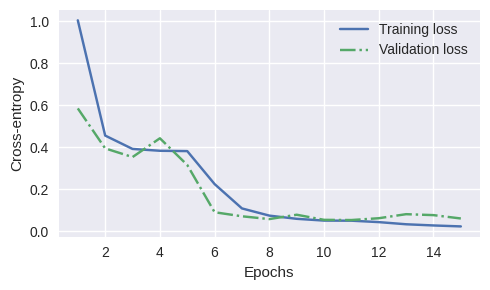

In [49]:
import matplotlib.pyplot as plt

def plot_learning_curve(history):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    epochs = range(1, len(history["train_loss"]) + 1)
    ax1.plot(epochs, history["train_loss"], label="Training loss")
    ax1.plot( epochs, history["val_loss"], linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Cross-entropy")
    ax1.legend()
    fig.tight_layout()
    plt.show()
    
plot_learning_curve(history)

La courbe d’apprentissage met en évidence une **phase d’apprentissage stable et efficace** : les pertes d’entraînement et de validation diminuent régulièrement durant les dix premières époques, ce qui montre que le modèle parvient à extraire progressivement des représentations utiles pour la tâche de classification.

À partir de l’**11ᵉ époque**, on observe une **légère dégradation de la performance sur le jeu de validation**, tandis que la perte d’entraînement continue de baisser. Ce comportement suggère que le modèle commence à **sur-apprendre** les spécificités du jeu d’entraînement plutôt que les régularités générales.


In [56]:
import time

torch.manual_seed(123)
gpt_classifier = GPTClassifier(cfg=GPT_SMALL_CONFIG_124M)
gpt_classifier.load_state_dict(state_dict_for_classif, strict=False)
optimizer = torch.optim.AdamW(gpt_classifier.parameters(), lr=5e-5, weight_decay=0.1)

start_time = time.time()

num_epochs = 5

trainer = Trainer(
    model=gpt_classifier,
    optimizer=optimizer,
    device=device,
    loss_fn=classification_loss
)
history = trainer.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

[Epoch 1/5] train_loss=0.5955 | val_loss=0.4212
[Epoch 2/5] train_loss=0.1699 | val_loss=0.0681
[Epoch 3/5] train_loss=0.0836 | val_loss=0.0605
[Epoch 4/5] train_loss=0.0706 | val_loss=0.0552
[Epoch 5/5] train_loss=0.0633 | val_loss=0.0540
Training completed in 22.33 minutes.


Nous pouvons maintenant calculer les metriques finales sur train, validation et test en parcourant tous les exemples :


In [ ]:
gpt_classifier.eval()

In [193]:
train_accuracy = classification_accuracy_loader(
    model=gpt_classifier,
    data_loader=train_loader,
    device=device
)

val_accuracy = classification_accuracy_loader(
    model=gpt_classifier,
    data_loader=val_loader,
    device=device
)

test_accuracy = classification_accuracy_loader(
    model=gpt_classifier,
    data_loader=test_loader,
    device=device
)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 98.37%
Validation accuracy: 97.92%
Test accuracy: 96.96%


Les performances obtenues après fine-tuning montrent que le modèle a su apprendre efficacement la structure du jeu de données tout en conservant une bonne capacité de généralisation. L’accuracy d’entraînement de 98,37 % indique que le modèle s’adapte très bien aux exemples vus lors de l’apprentissage, tandis que l’accuracy de validation de 97,92 % confirme que cette compréhension se transfère de manière robuste à des données nouvelles. Enfin, l’accuracy de test de 96,96 % montre que le modèle reste performant lorsqu’il est confronté à des exemples réellement inédits, sans signe majeur de surapprentissage.

Ces résultats sont déjà très satisfaisants, mais ils pourraient être améliorés en ajustant certains hyperparamètres, comme augmenter le taux de dropout ou renforcer le weight decay dans l’optimiseur, afin d’obtenir un entraînement plus robuste et mieux régularisé

## Utiliser le LLM comme classifieur de spam


Apres fine-tuning et evaluation, nous exploitons la fonction `classify_review` : elle reprend la meme preparation que `ClassificationDataset`, encode le texte puis appelle le modele pour prédire si le message est spam ou non.


In [140]:
MAX_TRAIN_TEXTS_LENGTH = 120 #train_dataset.max_length

def classify_review(
    text: str,
    model: GPTClassifier,
    tokenizer: GPTTokenizer,
    device: torch.device,
    *,
    max_length: Optional[int]=None,
    pad_token_id: int = 50256,
) -> Tuple[int, torch.Tensor]:

    model.eval()

    supported_context_length = model.pos_emb.weight.shape[0]
    input_ids = tokenizer.encode(text).tolist()
    
    if max_length is None:
        max_length = min(supported_context_length, max(MAX_TRAIN_TEXTS_LENGTH, len(input_ids)))
        
    input_ids = input_ids[:max_length]

    input_ids += [pad_token_id] * (max_length - len(input_ids))

    input_tensor = torch.tensor(
        input_ids, dtype=torch.long, device=device
    ).unsqueeze(0)

    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
        probs = torch.softmax(logits, dim=-1)

    predicted_label = torch.argmax(probs, dim=-1).item()

    return predicted_label, probs.squeeze(0).cpu()

In [190]:
text1 = (
"You are a winner you have been specially"
" selected to receive $1000 cash or a $2000 award."
)

In [191]:
classify_review(
    text=text1,
    model=gpt_classifier,
    tokenizer=tokenizer,
    device=device
)

(1, tensor([0.0243, 0.9757]))

Dans ce premier exemple, le modele predit correctement "spam". Essayons un second message :


In [187]:
text2 = (
"Hey, just wanted to check if we're still on"
" for dinner tonight? Let me know!"
)

In [189]:
classify_review(
    text=text2,
    model=gpt_classifier,
    tokenizer=tokenizer,
    device=device
)

(0, tensor([0.9963, 0.0037]))

Le modele renvoie a nouveau la bonne classe ("not spam"). Terminons en sauvegardant le modele pour le recharger sans refaire tout le fine-tuning.


In [ ]:
save_model(
    model=gpt_classifier,
    path="../assets/checkpoints/gpt_spam_classifier.pt"
)